# Labolatorium 7

## Dekompozycja spektralna

---
### Przydatne funkcje NumPy
- `numpy.linalg.eig`

---
### Przydatne importy

In [92]:
import numpy as np
import numpy.linalg as ln
import scipy.linalg as sln
import time
import matplotlib.pyplot as plt

---
### Metoda potęgowa

Napisz funkcje obliczającą metodą potęgową dominującą wartość własną (największą co do modułu) i odpowiadający jej wektor własny dla danej macierzy rzeczywistej symetrycznej. Sprawdź poprawność działania programu porównując własną implementację z wynikami funkcji bibliotecznej. Przedstaw na wykresie zależność czasu obliczeń od rozmiaru macierzy (rozmiar macierzy 100x100, 500x500, ...).

#### Funkcje pomocniczne

In [93]:
def get_symmetric_matrix(size):
    matrix = np.random.uniform(size=(size, size))
    return matrix + matrix.T - np.diag(matrix.diagonal())

def get_np_eig(matrix):
    np_eig_values, np_eig_vectors = ln.eig(matrix)
    max_i = np.argmax(abs(np_eig_values))
    
    return np_eig_vectors[:,max_i], np_eig_values[max_i]

#### Główna funkcja

In [94]:
def power_method(matrix, max_iterations=100000,  eps=10**(-12)):
    n = matrix.shape[0]
    x = np.random.uniform(size=(n, 1))
    for k in range(max_iterations):
        y = matrix @ x
        tmp = y / ln.norm(y, ord=np.inf) # as advised in kincaid & cheney
        
        if ln.norm(x - tmp) < eps: # ||x_i - x_i+1|| < e - our result is x_i+1
            x = tmp
            break

        x = tmp
    
    return k, (x / ln.norm(x)).reshape(n), ln.norm(y, ord=np.inf)

#### Sprawdzenie poprawności wyników i czasów wykonania

In [95]:
def benchmark(size, method, method_name, **kwargs):
    matrix = get_symmetric_matrix(size)
    start = time.time()
    _, eig_vector, eig_value = method(matrix, **kwargs)
    end = time.time()
    power_method_time = end - start
    
    np_start = time.time()
    np_eig_vector, np_eig_value = get_np_eig(matrix)
    np_end = time.time()
    np_eig_time = np_end - np_start
    
    print(f"\n------------ size = {size} ----------\n")
    print(f"{method_name} took {power_method_time}s to execute and returned eig value: {round(eig_value, 4)}")
    print(f"numpy.linalg.eig method took {np_eig_time}s to execute and returned eig value: {round(np_eig_value, 4)}")
    print(f"eig vectors equals: {np.allclose(abs(np_eig_vector), eig_vector, rtol=10**-6)}")

    return power_method_time, np_eig_time   

In [96]:
sizes = [100, 300, 500, 700, 1000, 1500]
times = np.array([ benchmark(n, power_method, "power method") for n in sizes])


------------ size = 100 ----------

power method took 0.0037946701049804688s to execute and returned eig value: 99.6288
numpy.linalg.eig method took 0.013854265213012695s to execute and returned eig value: 99.6288
eig vectors equals: True

------------ size = 300 ----------

power method took 0.0013079643249511719s to execute and returned eig value: 298.9649
numpy.linalg.eig method took 0.13639616966247559s to execute and returned eig value: 298.9649
eig vectors equals: True

------------ size = 500 ----------

power method took 0.0009541511535644531s to execute and returned eig value: 498.4806
numpy.linalg.eig method took 0.31716084480285645s to execute and returned eig value: 498.4806
eig vectors equals: True

------------ size = 700 ----------

power method took 0.001377105712890625s to execute and returned eig value: 699.9043
numpy.linalg.eig method took 0.653357744216919s to execute and returned eig value: 699.9043
eig vectors equals: True

------------ size = 1000 ----------

po

#### Przedstawienie wyników na wykresie

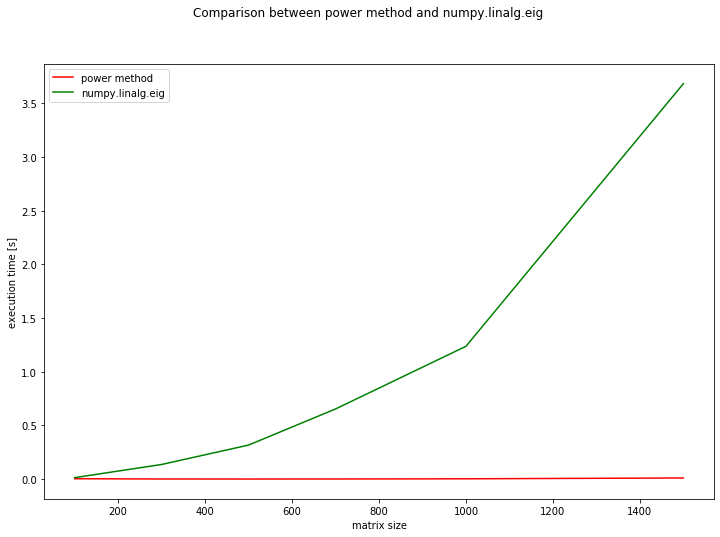

In [97]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Comparison between power method and numpy.linalg.eig")
ax1.plot(sizes, times[:, 0], 'r',label='power method')
ax1.plot(sizes, times[:, 1], 'g', label='numpy.linalg.eig')
ax1.legend()
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

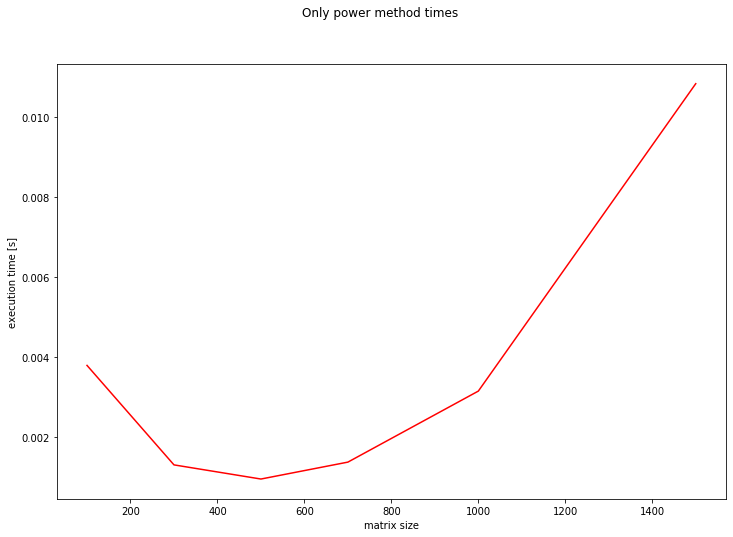

In [98]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Only power method times")
ax1.plot(sizes, times[:, 0], 'r')
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

Udało nam się uzyskać lepsze wyniki czasowe od funkcji bibliotecznej. Wynika to prawdopodobnie z tego, że metoda potęgowa ma pewne ograniczenia i nie działa zawsze, a funkcja biblioteczna jest przygotowana na różne przypadki macierzy. W przypadku losowych macierzy (nie symetrycznych) możliwe, że wyniki byłyby zupełnie inne (metoda potęgowa mogłaby w ogólnie nie zadziałać).

---
### Odwrotna metoda potęgowa
Opierając się na twierdzeniu o transformacji widma macierzy:

**Twierdzenie 1** *Macierz $(A - \sigma I)^{-1}$ (jeśli istnieje), to ma wartości własne równe $\frac{1}{\lambda _k - \sigma}$ ($\lambda_k$ jest k-tą wartością macierzy A) i wektory własne identyczne z macierzą A.*

oraz wykorzystując metodę potęgową i faktoryzację LU zaimplementuj odwrotną metodę potęgową pozwalającą na szybkie znalezienie wektorów własnych macierzy A, dla wartości $\sigma$ bliskich odpowiedniej wartości własnej. Wykorzystaj fakt, że mnozenie wektora $x_i$ przez macierz $A^{-1} (x_{i+1} = A^{-1}x_i)$ odpowiada rozwiązaniu układu równań $Ax_{i+1} = x_i$

In [99]:
def inverse_power_method(matrix, sigma, max_iterations=100,  eps=10**(-12)):
    n = matrix.shape[0]
    x = np.random.uniform(size=(n, 1))
    m_prim = matrix - sigma * np.identity(n)
    
    for k in range(max_iterations):
        P, L, U = sln.lu(m_prim)
        tmp = sln.solve_triangular(L, P @ x)
        y = sln.solve_triangular(U, tmp)
        y = y / ln.norm(y, ord=np.inf)
        
        if ln.norm(x - y) < eps: # ||x_i - x_i+1|| < e - our result is x_i+1
            x = y
            break

        x = y
        
    return k, (x / ln.norm(x)).reshape(n), sigma

#### Sprawdzenie poprawności wyników i czasów wykonania

In [100]:
def benchmark(size, method, method_name, eps=10**-6):
    matrix = get_symmetric_matrix(size)

    np_start = time.time()
    np_eig_vector, np_eig_value = get_np_eig(matrix)
    np_end = time.time()
    np_eig_time = np_end - np_start
    
    start = time.time()
    _, eig_vector, eig_value = method(matrix, np_eig_value+eps)
    end = time.time()
    power_method_time = end - start
    
    print(f"\n------------ size = {size} ----------\n")
    print(f"{method_name} took {power_method_time}s to execute and returned eig value: {round(eig_value, 4)}")
    print(f"numpy.linalg.eig method took {np_eig_time}s to execute and returned eig value: {round(np_eig_value, 4)}")
    print(f"eig vectors equals: {np.allclose(abs(np_eig_vector), abs(eig_vector), rtol=10**-4)}")
    return power_method_time, np_eig_time   

In [ ]:
sizes = [100, 300, 500, 700, 1000, 1500]
times = np.array([ benchmark(n, inverse_power_method, "inverse power method") for n in sizes])

#### Przedstawienie wyników na wykresie

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Comparison between inverse power method and numpy.linalg.eig")
ax1.plot(sizes, times[:, 0], 'r',label='inverse power method')
ax1.plot(sizes, times[:, 1], 'g', label='numpy.linalg.eig')
ax1.legend()
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Only inverse power method times")
ax1.plot(sizes, times[:, 0], 'r')
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

Odwrotna metoda potęgowa działa poprawnie. Jednak w praktyce okazało się, że jest ona wyraźnie wolniejsza niż zwykła metoda potęgowa. Można ją usprawnić - wykorzystać fakt, że im bardziej $\sigma$ zbiega do wartości własnej, tym szybciej ta metoda jest zbieżna. W tym celu można zastosować tzw. *iloraz Rayleigh*, czyli pod koniec każdej iteracji podstawić $\sigma = \frac{x^T_kA x_k}{x^T_kx_k}$.

In [101]:
Odwrotna metoda potęgowa działa poprawnie. Jednak w praktyce okazało się, że jest ona wyraźnie wolniejsza niż zwykła metoda potęgowa. Można ją usprawnić - wykorzystać fakt, że im bardziej $\sigma$ zbiega do wartości własnej, tym szybciej ta metoda jest zbieżna. W tym celu można zastosować tzw. *iloraz Rayleigh*, czyli pod koniec każdej iteracji podstawić $\sigma = \frac{x^T_kA x_k}{x^T_kx_k}$.


------------ size = 100 ----------

inverse power method took 0.11971235275268555s to execute and returned eig value: 99.6065
numpy.linalg.eig method took 0.015857934951782227s to execute and returned eig value: 99.6065
eig vectors equals: True

------------ size = 300 ----------

inverse power method took 0.38407254219055176s to execute and returned eig value: 299.4393
numpy.linalg.eig method took 0.10942244529724121s to execute and returned eig value: 299.4393
eig vectors equals: True

------------ size = 500 ----------

inverse power method took 0.7888298034667969s to execute and returned eig value: 499.969
numpy.linalg.eig method took 0.3151416778564453s to execute and returned eig value: 499.969
eig vectors equals: True

------------ size = 700 ----------

inverse power method took 1.4017906188964844s to execute and returned eig value: 700.4068
numpy.linalg.eig method took 0.6625292301177979s to execute and returned eig value: 700.4068
eig vectors equals: True

------------ size 

#### Przedstawienie wyników na wykresie

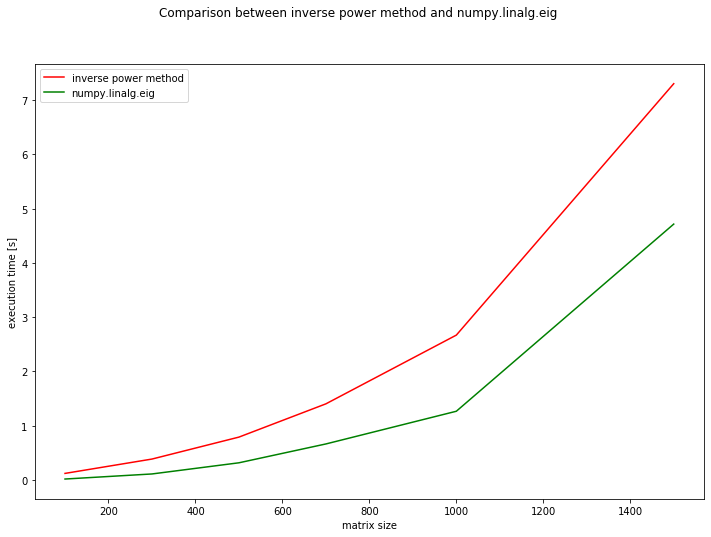

In [102]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Comparison between inverse power method and numpy.linalg.eig")
ax1.plot(sizes, times[:, 0], 'r',label='inverse power method')
ax1.plot(sizes, times[:, 1], 'g', label='numpy.linalg.eig')
ax1.legend()
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

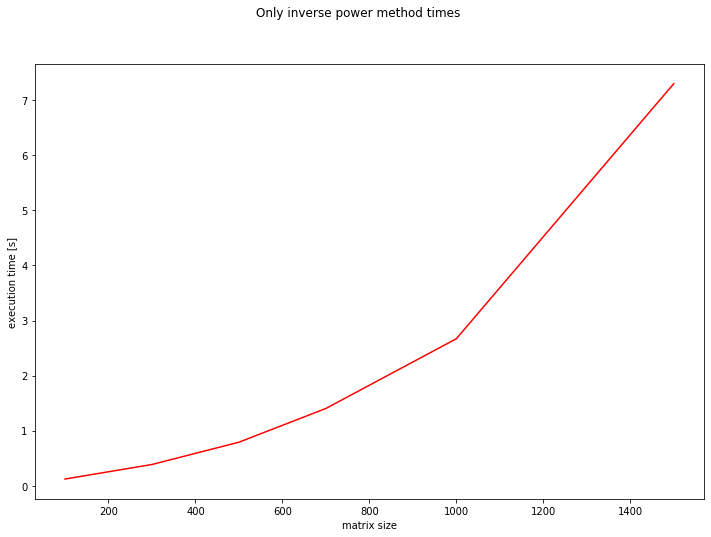

In [103]:
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
fig.suptitle("Only inverse power method times")
ax1.plot(sizes, times[:, 0], 'r')
ax1.set_xlabel("matrix size")
ax1.set_ylabel("execution time [s]")
plt.show()

Odwrotna metoda potęgowa działa poprawnie. Jednak w praktyce okazało się, że jest ona wyraźnie wolniejsza niż zwykła metoda potęgowa. Można ją usprawnić - wykorzystać fakt, że im bardziej $\sigma$ zbiega do wartości własnej, tym szybciej ta metoda jest zbieżna. W tym celu można zastosować tzw. *iloraz Rayleigh*, czyli pod koniec każdej iteracji podstawić $\sigma = \frac{x^T_kA x_k}{x^T_kx_k}$.